### Disclosure

This notebook file has as its porpuse running the data extraction as standard procedure and as such won't be documented in detail. The main ideas that must be retained are that the procedure follows what is intended in the assignment's sugestion and extraction code made available. The features are being extracted into files, which we didn't anex due to their size and lack of delivery purpose, and then fed into the models. We've extracted the MFCC's to feed the RNN and for the CNN we used the Mel Spectrograms as input.

### Dependencies

In [1]:
import soundata
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import numpy as np
import pickle
import pandas as pd

In [2]:
tf.keras.backend.clear_session()

In [3]:
# %store -r dataset_mfcc
# %store -r spectrogram_dataset

### Initializing the dataset

In [3]:
dataset = soundata.initialize('urbansound8k',data_home='urbansound')
# dataset.download(force_overwrite=True) #so that whenever you download it replaces the file even if it already exists or is corrupted
# #dataset.validate()
# dataset

### Feature Extraction

In [4]:
metadata = pd.read_csv('UrbanSound8K.csv')

In [5]:
metadata.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [ ]:
ax = sns.histplot(y='class',data = metadata, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45);
sns.despine()
plt.show()

In [6]:
metadata[metadata['slice_file_name'] == '100032-3-0-0.wav']['classID'][0]

3

In [7]:
a = []

In [8]:
metadata['slice_file_name']

0         100032-3-0-0.wav
1       100263-2-0-117.wav
2       100263-2-0-121.wav
3       100263-2-0-126.wav
4       100263-2-0-137.wav
               ...        
8727       99812-1-2-0.wav
8728       99812-1-3-0.wav
8729       99812-1-4-0.wav
8730       99812-1-5-0.wav
8731       99812-1-6-0.wav
Name: slice_file_name, Length: 8732, dtype: object

In [9]:
a.append(metadata[metadata['slice_file_name'] == '101415-3-0-2.wav']['classID'])

In [10]:
a

[64    3
 Name: classID, dtype: int64]

In [9]:
metadata[metadata['slice_file_name'] == '101415-3-0-2.wav']['classID'].values[0]

3

In [12]:
a

[64    3
 Name: classID, dtype: int64]

In [6]:
root_dir = "C:\\tmp\\sound_datasets\\urbansound8k\\audio\\fold"

In [7]:
# resampling freq
target_sr =44100

# MFCC parameters
n_mfcc=40
hop_length=round(target_sr*0.0125)
win_length=round(target_sr*0.023)
n_fft=2**14
mfcc_time_size = 4*target_sr//hop_length+1

# read all wav file without resampling
#dataset=np.zeros(shape=[8730,4*target_sr])
dataset_mfcc=np.zeros(shape=[8730,n_mfcc,mfcc_time_size])
spectrogram_dataset_reduced = np.zeros(shape=[8730,128,173])
spectrogram_dataset_more_reduced = np.zeros(shape=[8730,128,87])

In [8]:
spectrogram_dataset_reduced

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [9]:
#_wav_dir_="C:\\tmp\\sound_datasets\\urbansound8k\\audio\\fold1"
#files = librosa.util.find_files(wav_dir)

There have been some cases where the librosa function returned a different shape than expected and in such cases these values were discraded, and thus the 'erro' message printed.

In [8]:

i = 0
fold_pointer = []
file_names = []
labels_arr = []
error_count = 0

for j in range(0, 10):
    print(f"extracting fold {j+1}")
    dir_name = root_dir + str(j+1)
    files = librosa.util.find_files(dir_name)
    for f in files:
        file_name = str(f).replace(dir_name, '')
        (sig, rate) = librosa.load(str(f), sr=None)
        sig_res =librosa.resample(sig, orig_sr=rate, target_sr=target_sr)
        
        # zero padding
        if len(sig_res)<4*target_sr:
            sig_res_pad = np.concatenate((sig_res, np.zeros(4*target_sr-len(sig_res))),axis=0)

        else:
            sig_res_pad=sig_res

        #handling errors
        try:
            spectrogram_dataset_reduced[i] = librosa.feature.melspectrogram(y=sig_res_pad,sr=target_sr, hop_length = 1024)
            sig_mfcc =librosa.feature.mfcc(y=sig_res_pad,sr=target_sr,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)
            dataset_mfcc[i]=sig_mfcc
            labels_arr.append(metadata[metadata['slice_file_name'] == file_name[1:]]['classID'].values[0])
            file_names.append(file_name)
            i+=1

        except ValueError:
            print("erro")
            error_count+=1
            continue

    fold_pointer.append(i+1)

extracting fold 1


extracting fold 2
extracting fold 3
extracting fold 4
extracting fold 5
extracting fold 6
extracting fold 7
extracting fold 8
erro
erro
erro
erro
erro
erro
erro
extracting fold 9
extracting fold 10


In [9]:
fold_pointer

[874, 1762, 2687, 3677, 4613, 5436, 6274, 7073, 7889, 8726]

In [10]:
len(labels_arr)

8725

In [11]:
len(dataset_mfcc)

8730

In [12]:
len(spectrogram_dataset_reduced)

8730

In [13]:
spectrogram_dataset_reduced[8729]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
spectrogram_dataset_reduced[8724]

array([[4.48685745e-03, 5.50346795e-06, 1.15622352e-05, ...,
        2.10099461e-04, 7.18496667e-05, 4.89348080e-03],
       [5.88603504e-03, 2.86376569e-04, 1.24319759e-03, ...,
        5.69068419e-04, 2.40471377e-03, 6.76575629e-03],
       [8.14870279e-03, 3.05390870e-03, 9.66228172e-03, ...,
        3.87924872e-02, 1.41057502e-02, 7.62809115e-03],
       ...,
       [3.31137599e-05, 2.27977667e-04, 2.28453660e-03, ...,
        8.29369310e-06, 5.42635371e-06, 8.43918770e-06],
       [2.29900470e-05, 1.66288810e-05, 3.30576004e-05, ...,
        5.65234495e-06, 3.14958902e-06, 1.20857339e-05],
       [2.60089619e-05, 7.28803752e-06, 1.03307011e-05, ...,
        1.22949518e-06, 1.56546571e-06, 8.83742086e-06]])

In [16]:
spectrogram_dataset_reduced.shape

(8730, 128, 173)

In [18]:
len(labels_arr)

8725

In [23]:
spec_data = spectrogram_dataset_reduced[:-5]

In [24]:
spec_data.shape

(8725, 128, 173)

In [25]:
mfcc_data = dataset_mfcc[:-5]

In [26]:
mfcc_data.shape

(8725, 40, 321)

In [28]:
pointers = np.insert(fold_pointer, 0, 1)
pointers

array([   1,  874, 1762, 2687, 3677, 4613, 5436, 6274, 7073, 7889, 8726])

In [29]:
file_names

['\\101415-3-0-2.wav',
 '\\101415-3-0-3.wav',
 '\\101415-3-0-8.wav',
 '\\102106-3-0-0.wav',
 '\\102305-6-0-0.wav',
 '\\102842-3-0-1.wav',
 '\\102842-3-1-0.wav',
 '\\102842-3-1-5.wav',
 '\\102842-3-1-6.wav',
 '\\103074-7-0-0.wav',
 '\\103074-7-0-1.wav',
 '\\103074-7-0-2.wav',
 '\\103074-7-1-0.wav',
 '\\103074-7-1-1.wav',
 '\\103074-7-1-2.wav',
 '\\103074-7-1-3.wav',
 '\\103074-7-1-4.wav',
 '\\103074-7-1-5.wav',
 '\\103074-7-1-6.wav',
 '\\103074-7-2-0.wav',
 '\\103074-7-3-0.wav',
 '\\103074-7-3-1.wav',
 '\\103074-7-3-2.wav',
 '\\103074-7-3-3.wav',
 '\\103074-7-4-0.wav',
 '\\103074-7-4-1.wav',
 '\\103074-7-4-2.wav',
 '\\103074-7-4-3.wav',
 '\\103074-7-4-4.wav',
 '\\103074-7-4-5.wav',
 '\\103074-7-4-6.wav',
 '\\103258-5-0-0.wav',
 '\\103258-5-0-1.wav',
 '\\103258-5-0-10.wav',
 '\\103258-5-0-11.wav',
 '\\103258-5-0-12.wav',
 '\\103258-5-0-13.wav',
 '\\103258-5-0-14.wav',
 '\\103258-5-0-15.wav',
 '\\103258-5-0-16.wav',
 '\\103258-5-0-17.wav',
 '\\103258-5-0-18.wav',
 '\\103258-5-0-19.wav',
 

In [36]:
a = np.where(labels_arr==0)

In [37]:
len(a)

1

In [40]:
len(a[0])

1005

In [45]:
metadata[metadata['slice_file_name'] == '101415-3-0-3.wav']['classID'].values[0]

3

In [46]:
import pickle

# file_name = "mfcc_all_folds"
# with open(file_name,'wb') as my_file_obj:
#     pickle.dump(dataset_mfcc,my_file_obj)

file_name = "spec_data_v2"
with open(file_name,'wb') as my_file_obj:
    pickle.dump(spec_data,my_file_obj)

file_name = "mfcc_data_v2"
with open(file_name,'wb') as my_file_obj:
    pickle.dump(mfcc_data,my_file_obj)

file_name = "labels_v2"
with open(file_name,'wb') as my_file_obj:
    pickle.dump(labels_arr,my_file_obj)

file_name = "fold_pointers_v2"
with open(file_name,'wb') as my_file_obj:
    pickle.dump(pointers,my_file_obj)

file_name = "file_names"
with open(file_name,'wb') as my_file_obj:
    pickle.dump(file_names,my_file_obj)

# file_name = "labels"
# with open(file_name,'wb') as my_file_obj:
#     pickle.dump(labels_arr,my_file_obj)

In [16]:
file_name = "fold_pointers"
with open(file_name,'wb') as my_file_obj:
    pickle.dump(fold_pointer,my_file_obj)

In [ ]:
file_name = "spec_data_reduced"
with open(file_name,'wb') as my_file_obj:
    pickle.dump(spectrogram_dataset_reduced,my_file_obj)

In [16]:
%store dataset_mfcc
%store spectrogram_dataset
%store labels_arr

In [17]:
fold_pointer

[873, 1761, 2686, 3676, 4611, 5434, 6272, 7071, 7887, 8724]

In [13]:
len(labels_arr)

8724

In [18]:
for i in range(8722, 8729):
    print(spectrogram_dataset[i])

[[1.62045122e-03 1.04087824e-03 7.42838602e-04 ... 1.64337771e-03
  1.74021779e-03 2.52421945e-02]
 [1.29725672e-02 2.42544711e-02 2.27362942e-02 ... 1.33881420e-02
  5.97668393e-03 4.03967723e-02]
 [7.78450370e-02 9.59070101e-02 1.76068082e-01 ... 2.14531403e-02
  1.14658279e-02 2.72519682e-02]
 ...
 [1.69448307e-04 3.64821870e-04 4.56691720e-04 ... 9.23321873e-04
  5.83736284e-04 4.77086985e-04]
 [3.62339706e-05 5.34468491e-05 4.79046939e-05 ... 1.76004527e-04
  1.13224414e-04 1.25627761e-04]
 [1.47468973e-05 6.77283879e-06 3.51375706e-06 ... 4.77120848e-05
  4.67276986e-05 6.37895719e-05]]
[[4.48685745e-03 1.42953452e-03 5.50346795e-06 ... 7.18496667e-05
  3.00365908e-04 4.89348080e-03]
 [5.88603504e-03 2.01536808e-03 2.86376569e-04 ... 2.40471377e-03
  1.31271372e-03 6.76575629e-03]
 [8.14870279e-03 7.49719422e-03 3.05390870e-03 ... 1.41057502e-02
  1.17789069e-02 7.62809115e-03]
 ...
 [3.31137599e-05 6.42000887e-05 2.27977667e-04 ... 5.42635371e-06
  3.46102343e-06 8.43918770e-06]

In [14]:
len(dataset_mfcc)

8730

In [19]:
len(labels_arr)

8724

In [12]:
spectrogram_dataset[8723]

array([[4.48685745e-03, 1.42953452e-03, 5.50346795e-06, ...,
        7.18496667e-05, 3.00365908e-04, 4.89348080e-03],
       [5.88603504e-03, 2.01536808e-03, 2.86376569e-04, ...,
        2.40471377e-03, 1.31271372e-03, 6.76575629e-03],
       [8.14870279e-03, 7.49719422e-03, 3.05390870e-03, ...,
        1.41057502e-02, 1.17789069e-02, 7.62809115e-03],
       ...,
       [3.31137599e-05, 6.42000887e-05, 2.27977667e-04, ...,
        5.42635371e-06, 3.46102343e-06, 8.43918770e-06],
       [2.29900470e-05, 2.20254806e-05, 1.66288810e-05, ...,
        3.14958902e-06, 3.70091561e-06, 1.20857339e-05],
       [2.60089619e-05, 1.43086590e-05, 7.28803752e-06, ...,
        1.56546571e-06, 1.94382710e-06, 8.83742086e-06]])

In [9]:
len(dataset_mfcc)

8730

In [11]:
spectrogram_dataset[8000]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
import pandas as pd

metadata = pd.read_csv('UrbanSound8K.csv') 

metadata.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [9]:
test_data = metadata.__deepcopy__()
test_data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [10]:
%store dataset_mfcc
dataset_mfcc[0]
#dataset_mfcc.tofile('mfcc.csv', sep=',')

Stored 'dataset_mfcc' (ndarray)


array([[-463.11437988, -459.11575317, -457.93478394, ..., -373.82531738,
        -348.72229004, -222.5680542 ],
       [   6.40507984,   11.90687752,   13.64982986, ...,  113.06309509,
         137.97808838,  149.25341797],
       [   6.24001122,   11.29660988,   13.24950409, ...,   68.03630066,
          73.55275726,   30.44655609],
       ...,
       [   1.69177103,   -1.88172507,   -1.18501472, ...,  -13.50051498,
           0.69385326,   -0.62134945],
       [   1.8546102 ,   -1.54264736,   -1.28383601, ...,  -11.77211189,
           0.88274819,   -1.96269238],
       [   1.98306143,   -1.20623755,   -1.36647367, ...,   -4.00553226,
           2.95869207,    3.22776675]])

In [11]:
%store spectrogram_dataset
spectrogram_dataset[0]

Stored 'spectrogram_dataset' (ndarray)


array([[9.22176187e-05, 7.01832541e-05, 2.03987947e-05, ...,
        2.88242823e-04, 7.24560115e-04, 6.12167222e-03],
       [8.59618740e-05, 1.78999093e-04, 5.33761224e-04, ...,
        8.13090475e-04, 3.46970931e-03, 1.35818226e-02],
       [6.88650398e-05, 6.25248300e-04, 1.67922862e-03, ...,
        1.35617773e-03, 4.76711895e-03, 3.22338194e-02],
       ...,
       [7.02667835e-09, 1.37795402e-08, 1.65571450e-08, ...,
        2.24688979e-08, 4.55356940e-07, 1.74187116e-05],
       [1.32673605e-09, 2.59812971e-09, 1.98949079e-09, ...,
        2.45731036e-09, 2.57295397e-07, 1.06137295e-05],
       [2.01663367e-10, 8.38841774e-11, 5.07661482e-11, ...,
        5.86211149e-11, 1.62421387e-07, 6.93119364e-06]])

In [12]:
# import pickle

# file_name = "mfcc_shared"
# with open(file_name,'wb') as my_file_obj:
#     pickle.dump(dataset_mfcc,my_file_obj)

# file_name = "spec_data_shared"
# with open(file_name,'wb') as my_file_obj:
#     pickle.dump(spectrogram_dataset,my_file_obj)

In [15]:
spectrogram_dataset[0]

array([[9.22176187e-05, 7.01832541e-05, 2.03987947e-05, ...,
        2.88242823e-04, 7.24560115e-04, 6.12167222e-03],
       [8.59618740e-05, 1.78999093e-04, 5.33761224e-04, ...,
        8.13090475e-04, 3.46970931e-03, 1.35818226e-02],
       [6.88650398e-05, 6.25248300e-04, 1.67922862e-03, ...,
        1.35617773e-03, 4.76711895e-03, 3.22338194e-02],
       ...,
       [7.02667835e-09, 1.37795402e-08, 1.65571450e-08, ...,
        2.24688979e-08, 4.55356940e-07, 1.74187116e-05],
       [1.32673605e-09, 2.59812971e-09, 1.98949079e-09, ...,
        2.45731036e-09, 2.57295397e-07, 1.06137295e-05],
       [2.01663367e-10, 8.38841774e-11, 5.07661482e-11, ...,
        5.86211149e-11, 1.62421387e-07, 6.93119364e-06]])

In [16]:
dataset_mfcc[0]

array([[-463.11437988, -459.11575317, -457.93478394, ..., -373.82531738,
        -348.72229004, -222.5680542 ],
       [   6.40507984,   11.90687752,   13.64982986, ...,  113.06309509,
         137.97808838,  149.25341797],
       [   6.24001122,   11.29660988,   13.24950409, ...,   68.03630066,
          73.55275726,   30.44655609],
       ...,
       [   1.69177103,   -1.88172507,   -1.18501472, ...,  -13.50051498,
           0.69385326,   -0.62134945],
       [   1.8546102 ,   -1.54264736,   -1.28383601, ...,  -11.77211189,
           0.88274819,   -1.96269238],
       [   1.98306143,   -1.20623755,   -1.36647367, ...,   -4.00553226,
           2.95869207,    3.22776675]])

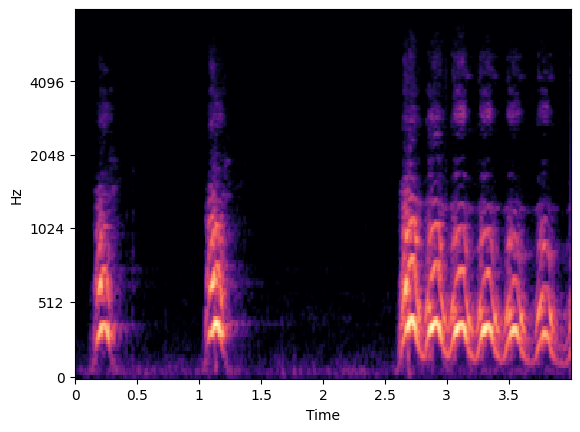

In [22]:
import librosa.display


fig, ax = plt.subplots()

S_dB = librosa.power_to_db(spectrogram_dataset[0], ref=np.max)

img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=44100, fmax=8000, ax=ax)

# fig.colorbar(img, ax=ax, format='%+2.0f dB')
plt.bounds
plt.savefig('spec_images/image.png')

# ax.set(title='Mel-frequency spectrogram example')

In [14]:
test_data['image_data'] = np.nan

test_data

,slice_file_name,fsID,start,end,salience,fold,classID,class,image_data
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,NaN
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,NaN
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,NaN
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,NaN
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,NaN
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,NaN
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,NaN
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,NaN
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,NaN
